In [1]:
from qutip import *
from qutip.measurement import measure, measurement_statistics
import numpy as np
import matplotlib.pyplot as plt


In [217]:
N=65
#cavity operators
ac = destroy(N)
nb_op = ac.dag()*ac
ic = qeye(N)
#qubit operators
aq = destroy(2)
hq = (sigmax()+sigmaz())/np.sqrt(2)
iq = qeye(2)
g_proj = (iq+sigmaz())/2
e_proj = (iq-sigmaz())/2

# Experimental values

In [430]:
# frequencies
X_e0 = 2*np.pi*-93e3

X_f0 = 2*np.pi*-236e3

X_g0 = 0

#decay times

ge_decay_time = 25e-6

# Initial state

In [227]:
alpha = np.sqrt(2)
cat_state = (coherent(N,alpha)+coherent(N,-alpha)).unit()

In [228]:
ket2dm(tensor((basis(2,0)+basis(2,1)).unit(), cat_state))

Quantum object: dims = [[2, 65], [2, 65]], shape = (130, 130), type = oper, isherm = True
Qobj data =
[[0.13290111 0.         0.18795056 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.18795056 0.         0.26580223 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]

# ge Parity Protocol

In [443]:
def ge_parity(cavity_state, collapse = []):
    
    H_int = X_e0*tensor(e_proj, nb_op)
    #H_parity = X_e*tensor(sigmaz(),nb_op)
    t = np.abs(np.pi/(X_e0))
    
    
    # prepare cat state and initial state
    psi0 = tensor((basis(2,0)+basis(2,1)).unit(), cavity_state)
      
    result = mesolve(H_int, psi0, np.linspace(0,t,200), c_ops = collapse)  
    
    psi = result.states[-1]
    
    psi = tensor(hq,ic)*psi
    return psi

In [456]:
ge_no_error = ge_parity(cat_state)

In [458]:
ge_no_error.ptrace(0)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[9.99999994e-01+0.00000000e+00j 4.58912264e-05-7.06603436e-06j]
 [4.58912264e-05+7.06603436e-06j 5.70372771e-09+0.00000000e+00j]]

In [463]:
fidelity(ge_no_error.ptrace(1), ket2dm(cat_state))

1.0000035159613805

## Relaxation error added

In [444]:
#collapse operator for relaxation
ge_error_rate = np.sqrt(1/ge_decay_time)
ge_relax = ge_error_rate*tensor(sigmap(),ic)

In [445]:
ge_error_rate

200.0

In [450]:
psi_ge = ge_parity(cat_state, [ge_relax])

In [451]:
psi_ge.ptrace(0)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[0.73947492+1.0422505e-07j 0.6026484 -1.0422505e-07j]
 [0.10445838-1.0422505e-07j 0.03236814-1.0422505e-07j]]

(<Figure size 800x600 with 1 Axes>,
 <AxesSubplot: xlabel='Fock number', ylabel='Occupation probability'>)

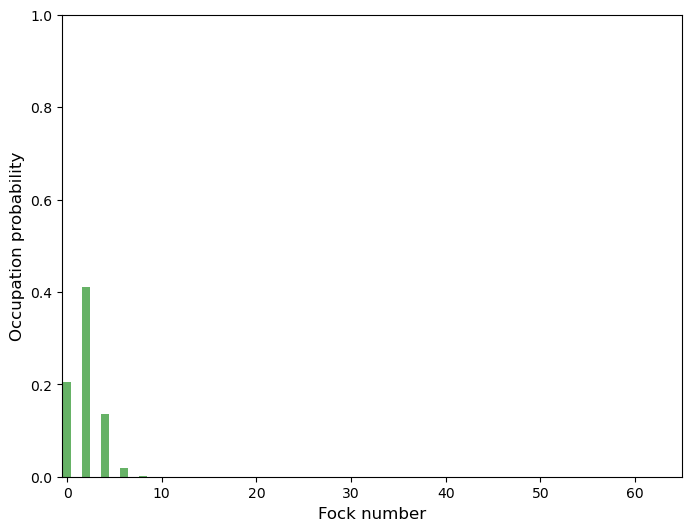

In [452]:
plot_fock_distribution(psi_ge.ptrace(1))

(<Figure size 600x600 with 1 Axes>,
 <AxesSubplot: title={'center': 'Wigner function'}, xlabel='$\\rm{Re}(\\alpha)$', ylabel='$\\rm{Im}(\\alpha)$'>)

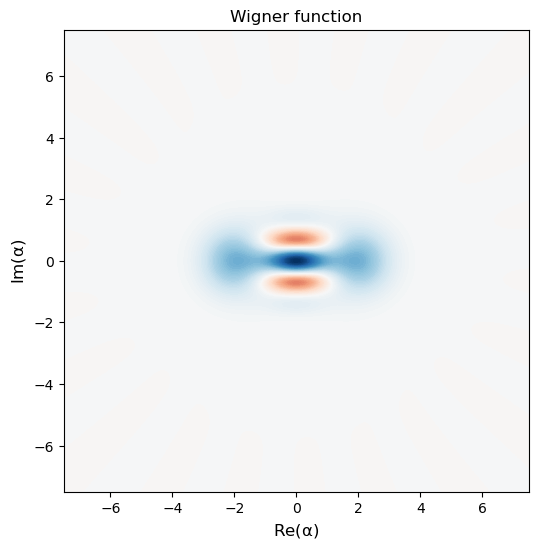

In [453]:
plot_wigner(psi_ge.ptrace(1))

In [454]:
fidelity(ket2dm(cat_state),psi_ge.ptrace(1))

0.8543019906713653

# gf Parity Protocol

In [333]:
#Three level ancilla operators
a3 = destroy(3)

half_pi_pulse_ge = Qobj([[1,1j,0],[1j,1,0],[0,0,np.sqrt(2)]]/np.sqrt(2))

pi_pulse_ef = Qobj([[1,0,0],[0,0,1j],[0,1j,0]])

iq3 = qeye(3)
g_proj3 = Qobj([[1,0,0],[0,0,0],[0,0,0]])
e_proj3 = Qobj([[0,0,0],[0,1,0],[0,0,0]])
f_proj3 = Qobj([[0,0,0],[0,0,0],[0,0,1]])
fe_proj = Qobj([[0,0,0],[0,0,1],[0,0,0]])

In [376]:
def gf_parity(cavity, collapse = []):
    chi = 1
    alpha = np.sqrt(2)
    nb_op = ac.dag()*ac

    H_int = X_e0*tensor(e_proj3, nb_op)+X_e0*tensor(f_proj3,nb_op)
    t = np.pi/np.abs(X_f0-X_g0)
    
    
    # prepare initial state
    qubit = basis(3,0)
    qubit = half_pi_pulse_ge*qubit
    qubit = pi_pulse_ef*qubit
    psi0 = tensor(qubit,cavity) 
    
    
    #result = mesolve(H_int, psi0, np.linspace(0,t,100))
    result = mesolve(H_int, psi0, np.linspace(0,t,100), c_ops = collapse)
    
    
    psi = result.states[-1]
    
    psi = tensor(pi_pulse_ef,ic)*psi
    psi = tensor(half_pi_pulse_ge,ic)*psi
    
    return psi

In [391]:
#error operators
fe_relax = tensor(fe_proj, ic)

In [386]:
psi_gf = gf_parity(cat_state)

(<Figure size 800x600 with 1 Axes>,
 <AxesSubplot: xlabel='Fock number', ylabel='Occupation probability'>)

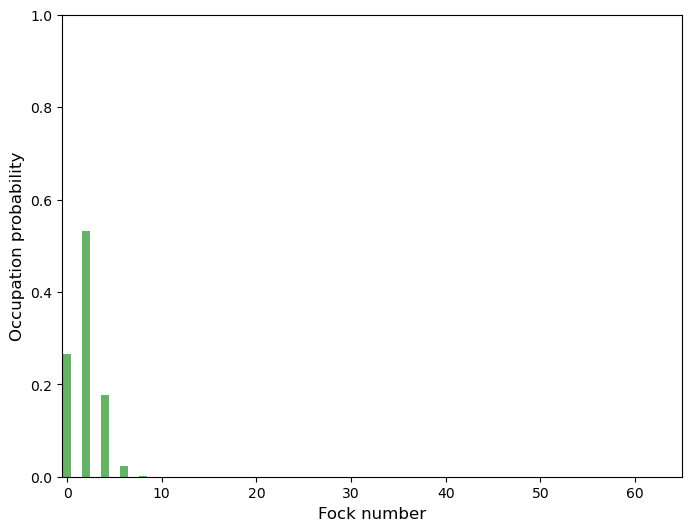

In [387]:
plot_fock_distribution(psi_gf.ptrace(1))

(<Figure size 600x600 with 1 Axes>,
 <AxesSubplot: title={'center': 'Wigner function'}, xlabel='$\\rm{Re}(\\alpha)$', ylabel='$\\rm{Im}(\\alpha)$'>)

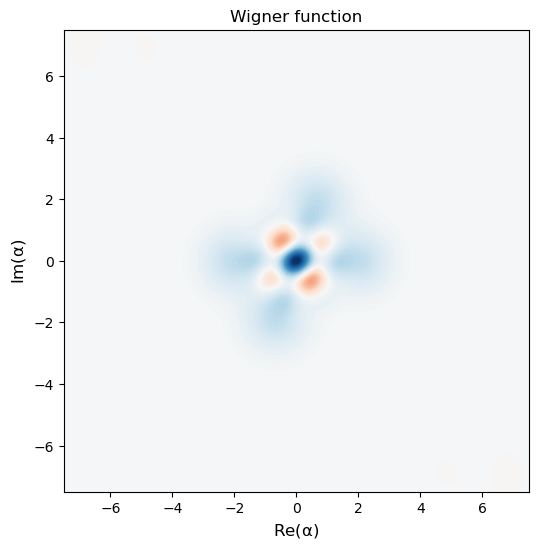

In [388]:
plot_wigner(psi_gf.ptrace(1))

In [389]:
fidelity(psi_gf.ptrace(1),(coherent(N,alpha)+coherent(N,-alpha)).unit())

0.7217142770105771

In [390]:
psi_gf.ptrace(0)

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.44902992+0.00000000e+00j 0.08844075-2.81094047e-05j
  0.        +0.00000000e+00j]
 [0.08844075+2.81094047e-05j 0.55097008+0.00000000e+00j
  0.        +0.00000000e+00j]
 [0.        +0.00000000e+00j 0.        +0.00000000e+00j
  0.        +0.00000000e+00j]]